In [1]:
#Capstone 2

#Modelling

In [22]:
#imports
import pandas as pd
import numpy as np
import datetime as dt

# Import regression modules
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import sklearn.model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.stats import expon
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR



# Show plots inline
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
mpl.style.reload_library()
import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
#Import the dataframe

new_df = pd.read_csv('new_df.csv')
new_df = new_df[['index', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']]
new_df

,index,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Housing prices LA,254.000000,208.00,176.000000,174.000000,166.000000,165.000,180.000000,204.000000,216.000,232.000000,248.000000,265.000000,274.000000,281.000000,314.000000,363.000000,375.000000
1,Unemployment rate LA,5.100000,7.50,11.700000,12.600000,12.200000,11.000,9.800000,8.200000,6.700,5.300000,4.800000,4.700000,4.500000,12.400000,9.000000,5.000000,5.000000
2,Obama ACA Indicator,0.000000,0.00,0.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
3,"CPI California, Urban Consumers",217.000000,225.00,224.000000,227.000000,233.000000,238.000,242.000000,246.000000,250.000,255.000000,263.000000,273.000000,281.000000,285.000000,297.000000,319.000000,332.000000
4,"Healthcare Cost, California",209334.000000,220894.00,229415.000000,241845.000000,253703.000000,267048.000,277008.000000,288330.000000,311146.000,325931.000000,338088.000000,357648.000000,379715.000000,405451.000000,426104.673940,447810.446031,470621.910151
5,CA unemployment rate,5.308333,7.30,11.541667,12.458333,11.891667,10.525,9.033333,7.566667,6.225,5.516667,4.833333,4.258333,4.100000,10.191667,7.325000,4.275000,4.741667
6,CA Housing prices,608.285000,486.74,421.292500,408.630000,387.325000,388.390,435.887500,487.855000,522.490,559.445000,596.040000,634.745000,655.270000,683.090000,779.145000,900.000000,915.810000
7,Overall Homeless CA,138986.000000,181399.00,171521.000000,57468.000000,161548.000000,151278.000,129972.000000,131532.000000,118142.000,115738.000000,113952.000000,118552.000000,120098.000000,125128.000000,123480.000000,123678.000000,136531.000000
8,CA-500,9903.000000,10028.00,2301.000000,9605.000000,9706.000000,7254.000,7394.000000,6524.000000,6556.000,7567.000000,7631.000000,7053.000000,7067.000000,7086.000000,7086.000000,7202.000000,7202.000000
9,CA-501,7582.000000,7754.00,4000.000000,8124.000000,8035.000000,6857.000,6858.000000,6996.000000,6775.000,6408.000000,7008.000000,5895.000000,5669.000000,5823.000000,5823.000000,5171.000000,5703.000000


In [4]:
new_df.shape

(52, 18)

In [5]:
#In this section I separate the time-series data into train and test groups, discarding the columns with string data.

# Create a subset of the DataFrame with only numeric columns, excluding 'index' and the target year '2023'
X = new_df.drop(['index', '2023'], axis=1)
y = new_df['2023']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the numeric columns
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back into a DataFrame to retain column names and indices
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# PCA dimension reduction 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)

# TimeSeriesSplit with 4 splits
tscv = TimeSeriesSplit(n_splits=4)

for train_index, test_index in tscv.split(X_pca):
    # Print the indices for clarity
    print("TRAIN indices:", train_index, "TEST indices:", test_index)

    # Using .iloc to avoid KeyError and ensure indexing works correctly
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Display the shapes of the training and test sets
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST indices: [12 13 14 15 16 17 18 19 20 21]
X_train shape: (12, 2), X_test shape: (10, 2)
y_train shape: (12,), y_test shape: (10,)
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST indices: [22 23 24 25 26 27 28 29 30 31]
X_train shape: (22, 2), X_test shape: (10, 2)
y_train shape: (22,), y_test shape: (10,)
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31] TEST indices: [32 33 34 35 36 37 38 39 40 41]
X_train shape: (32, 2), X_test shape: (10, 2)
y_train shape: (32,), y_test shape: (10,)
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41] TEST indices: [42 43 44 45 46 47 48 49 50 51]
X_train shape: (42, 2), X_test shape: (10, 2)
y_train shape: (42,), y_test shape: (10,)


In [6]:
#I run a linear regression.

# Initialize and train the model using the PCA-reduced training data
linear = LinearRegression()
linear.fit(X_train, y_train)

# Predict the values using the PCA-reduced test data
y_test_pred = linear.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R-squared score
r_squared = r2_score(y_test, y_test_pred)
print(f"R-squared Score: {r_squared}")


Mean Squared Error (MSE): 2036302.027513904
R-squared Score: 0.5093112341658379


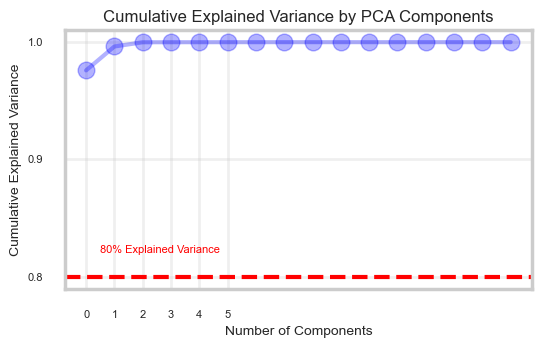

Number of components explaining at least 80% variance: 1


In [7]:
#PCA
pca = PCA()  
pca.fit(X_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(6, 4))  

# Plot the cumulative explained variance
plt.plot(cumulative_explained_variance, marker='o', color='b', alpha =0.3)

# Add labels and title with smaller fonts
plt.title('Cumulative Explained Variance by PCA Components', fontsize=12)
plt.xlabel('Number of Components', fontsize=10)
plt.ylabel('Cumulative Explained Variance', fontsize=10)

# Make the numerals on the axis smaller
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Add ticks between 0 and 5 for x-axis
plt.xticks(np.arange(0, 6, 1))

# Add a horizontal line for 80% threshold
plt.axhline(y=0.80, color='r', linestyle='--')
plt.text(0.5, 0.82, '80% Explained Variance', color='red', fontsize=8)

plt.grid(True, alpha=0.3)
plt.tight_layout()  
plt.show()

# Find the number of components that explain at least 80% of the variance
n_components_80 = np.argmax(cumulative_explained_variance >= 0.80) + 1
print(f'Number of components explaining at least 80% variance: {n_components_80}')

In order to explain 80% of the variance I should use one component, but I would like to account for additional variance without accounting for all of the variance and thus over-fitting the model. I will stick with two components, it is likely to overfit for the earlier data but given the error values towards the upward trend after 2020 it is still likely to make errors and not overfit for future predictions. 

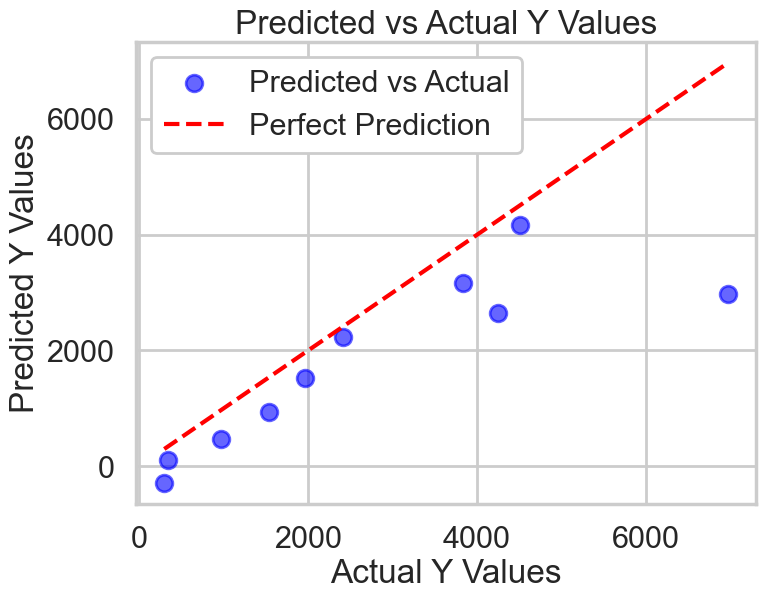

In [9]:
# Plot the predicted vs actual values
plt.figure(figsize=(8, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.6, label='Predicted vs Actual')

# Add a diagonal line representing a perfect prediction
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Add labels and title
plt.xlabel('Actual Y Values')
plt.ylabel('Predicted Y Values')
plt.title('Predicted vs Actual Y Values')

# Add legend
plt.legend(loc='best', facecolor='white', framealpha=1)

# Show the plot
plt.show()

It looks okay to use a linear model, but this is time-series data, so I will check for lags and see whether it is better to use a time-series function to model the data.

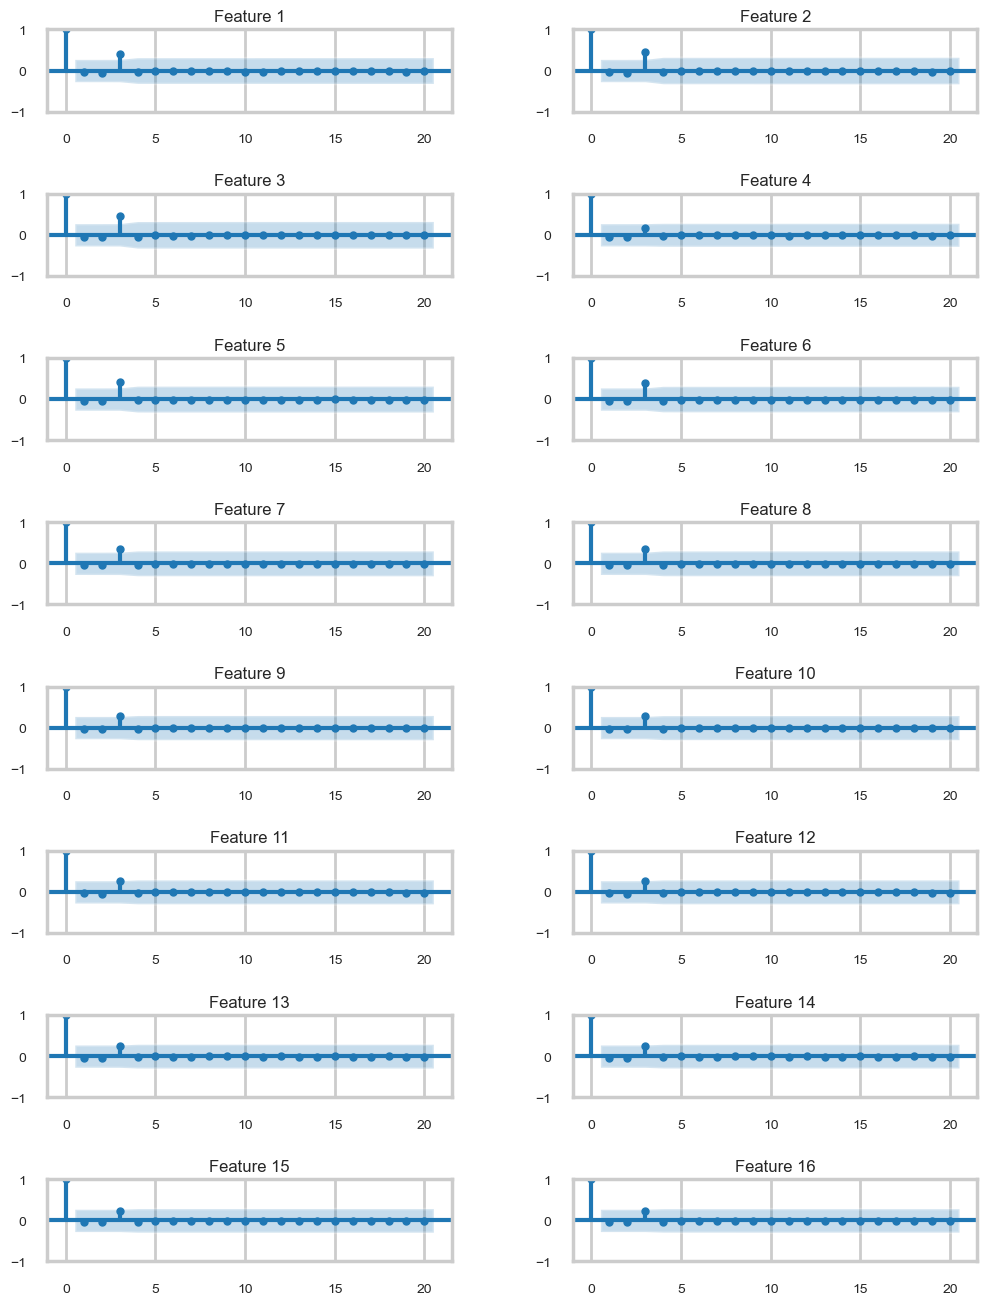

In [11]:
#Plotting the auto-correlation functions for each year.

# Define number of features and the layout (8 rows, 2 columns)
num_features = X_scaled.shape[1]
rows = 8
cols = 2

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 16))  

# Plot the ACF for each feature
for i in range(num_features):
    row = i // cols  
    col = i % cols   
    ax = axes[row, col]
    plot_acf(X_scaled[:, i], lags=20, alpha=0.05, ax=ax)
    ax.set_title(f'Feature {i+1}', fontsize=12)
    
    # Set x and y axis label font size to match the title
    ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust spacing between subplots (increase wspace and hspace)
plt.subplots_adjust(hspace=1, wspace=0.3)

# Show the plot with improved spacing and label sizes
plt.show()


ADF Statistic: -7.306987353883723
p-value: 1.2937636235898375e-10


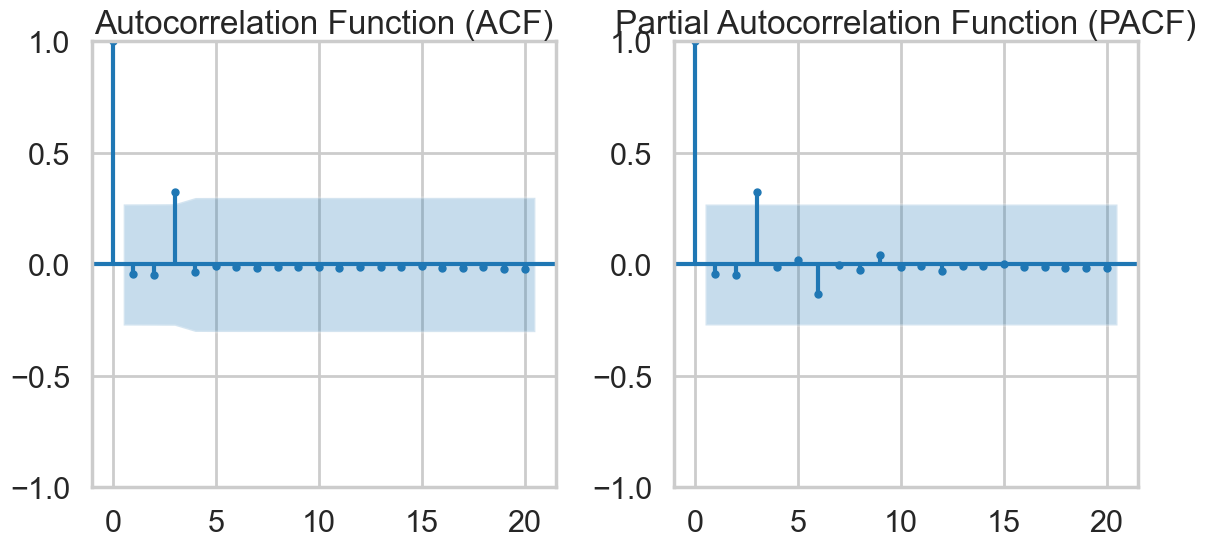

In [12]:
#It looks like there might be the slightest amount of auto-correlation in year three, let's see if it is there in the 
#PCA components.

# Perform PCA to reduce to one component
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled_df)

# Convert the PCA result to a DataFrame for easier handling
X_pca_df = pd.DataFrame(X_pca, columns=['Principal Component'])

# Now you can use the PCA result as your univariate series
X_train_univariate = X_pca_df['Principal Component']

# Perform the Augmented Dickey-Fuller test
result = adfuller(X_train_univariate)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# ACF and PACF plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(X_train_univariate, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(X_train_univariate, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In the AD Fuller statistic we can tell the data is stationary. It looks like the correct number of lags will be less than five.

In [14]:
#ARIMA Model 1

# Fit the ARIMA model with chosen parameters
mod = ARIMA(X_train_univariate, order=(1, 0, 0))  
result = mod.fit()

# Predict using the ARIMA model
y_pred = result.predict()

# Print summary of the ARIMA model
print(result.summary())


                                SARIMAX Results                                
Dep. Variable:     Principal Component   No. Observations:                   52
Model:                  ARIMA(1, 0, 0)   Log Likelihood                -145.192
Date:                 Fri, 11 Oct 2024   AIC                            296.384
Time:                         11:33:47   BIC                            302.238
Sample:                              0   HQIC                           298.628
                                  - 52                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      3.979      0.000      1.000      -7.797       7.799
ar.L1         -0.0420      4.335     -0.010      0.992      -8.538       8.454
sigma2        15.5861      2.780      5.607 

In [15]:
# Fit ARIMA model on additional lags
mod2 = ARIMA(X_train_univariate, order=(4, 0, 0))  
result2 = mod2.fit()

# Predict using the ARIMA model
y_pred2 = result2.predict()

# Print summary of the ARIMA model
print(result.summary())

                                SARIMAX Results                                
Dep. Variable:     Principal Component   No. Observations:                   52
Model:                  ARIMA(1, 0, 0)   Log Likelihood                -145.192
Date:                 Fri, 11 Oct 2024   AIC                            296.384
Time:                         11:33:47   BIC                            302.238
Sample:                              0   HQIC                           298.628
                                  - 52                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      3.979      0.000      1.000      -7.797       7.799
ar.L1         -0.0420      4.335     -0.010      0.992      -8.538       8.454
sigma2        15.5861      2.780      5.607 

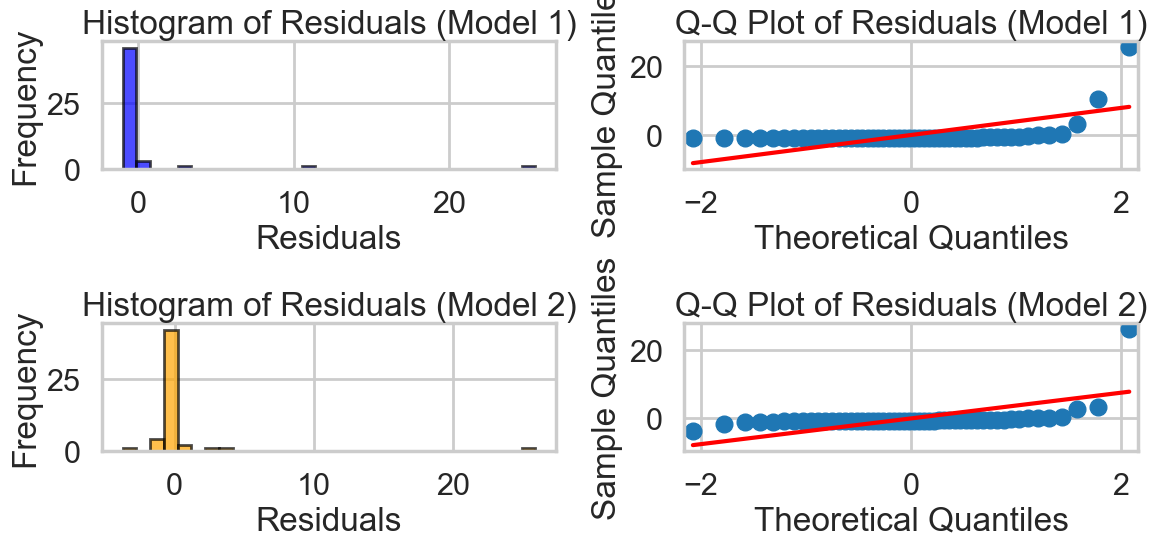

In [16]:
# Residuals from the fitted ARIMA models
residuals1 = result.resid  # Residuals from the first model
residuals2 = result2.resid  # Residuals from the second model

# Create a figure with subplots for histogram and Q-Q plot
plt.figure(figsize=(12, 6))

# Histogram for the first model
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, first subplot
plt.hist(residuals1, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Residuals (Model 1)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Q-Q plot for the first model
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, second subplot
sm.qqplot(residuals1, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals (Model 1)')

# Histogram for the second model
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, third subplot
plt.hist(residuals2, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Histogram of Residuals (Model 2)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Q-Q plot for the second model
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, fourth subplot
sm.qqplot(residuals2, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals (Model 2)')

plt.tight_layout()
plt.show()


In [17]:
# Define a TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Placeholder for metrics
arima_mse_scores = []

# Cross-validation loop
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Select a univariate series from X_train for ARIMA
    y_train_univariate = X_train[:, 0]  
    y_test_univariate = X_test[:, 0]  # Corresponding test set

    # Fit ARIMA model
    model = ARIMA(y_train_univariate, order=(1, 0, 0))  
    result = model.fit()

    # Make predictions
    y_pred = result.predict(start=len(y_train_univariate), end=len(y_train_univariate) + len(y_test_univariate) - 1)

    # Calculate and store MSE
    mse = mean_squared_error(y_test_univariate, y_pred)
    arima_mse_scores.append(mse)

print("ARIMA MSE Scores:", arima_mse_scores)
print("Average MSE:", np.mean(arima_mse_scores))


ARIMA MSE Scores: [0.8232445008828726, 0.28875381936427336, 0.16689813981394258, 0.4284484050792737, 0.0767696582109092]
Average MSE: 0.3568229046702543


In [18]:
# Define a TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Placeholder for metrics
arima_mse_scores = []

# Cross-validation loop
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Select a univariate series from X_train for ARIMA
    y_train_univariate = X_train[:, 0]  
    y_test_univariate = X_test[:, 0]  # Corresponding test set

    # Fit ARIMA model
    model = ARIMA(y_train_univariate, order=(4, 0, 0))  
    result = model.fit()

    # Make predictions
    y_pred = result.predict(start=len(y_train_univariate), end=len(y_train_univariate) + len(y_test_univariate) - 1)

    # Calculate and store MSE
    mse = mean_squared_error(y_test_univariate, y_pred)
    arima_mse_scores.append(mse)

print("ARIMA2 MSE Scores:", arima_mse_scores)
print("Average MSE:", np.mean(arima_mse_scores))


ARIMA2 MSE Scores: [1.925674247900199, 0.2028152275174579, 0.09855641689779224, 0.42116319640969735, 0.05163774483800012]
Average MSE: 0.5399693667126293


In [19]:
#A VaR Model without PCA

# Create a subset of the DataFrame with only numeric columns, excluding 'index' and the target year '2023'
X = new_df.drop(['index', '2023'], axis=1)
y = new_df['2023']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the numeric columns
X_scaled = scaler.fit_transform(X)


# TimeSeriesSplit with 4 splits
tscv = TimeSeriesSplit(n_splits=4)

for train_index, test_index in tscv.split(X_scaled):

    # Using .iloc to avoid KeyError and ensure indexing works correctly
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


# Ensure that X_train is a DataFrame 
X_train_df = pd.DataFrame(X_train)

# Fit the VAR model 
model_var = VAR(X_train_df)
results_var = model_var.fit(ic='aic')  

# View the summary of the model
print(results_var.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 11, Oct, 2024
Time:                     11:33:48
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                   -132.773
Nobs:                     41.0000    HQIC:                  -140.001
Log likelihood:           2296.07    FPE:                5.88159e-63
AIC:                     -144.141    Det(Omega_mle):     2.28659e-65
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.062879         0.249987            0.252           0.801
L1.0          1.953479        38.166247            0.051           0.959
L1.1         -8.154118        45.948787           -0.177           0.859
L1.2         -6.876719 

In [20]:
# Placeholder for metrics
var_mse_scores = []

# Cross-validation loop
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ensure X_train is a DataFrame
    X_train_df = pd.DataFrame(X_train)
    
    # Fit VAR model
    model_var = VAR(X_train_df)
    results_var = model_var.fit()

    # Forecasting
    y_pred = results_var.forecast(X_train_df.values[-results_var.k_ar:], steps=len(X_test))

    # Calculate and store MSE
    mse = mean_squared_error(y_test, y_pred[:, 0])  
    var_mse_scores.append(mse)

print("VAR MSE Scores:", var_mse_scores)
print("Average MSE:", np.mean(var_mse_scores))


VAR MSE Scores: [354806659460.1925, 3258731.234438983, 235845996.07972065, 11479199.778941542]
Average MSE: 88764310846.8214


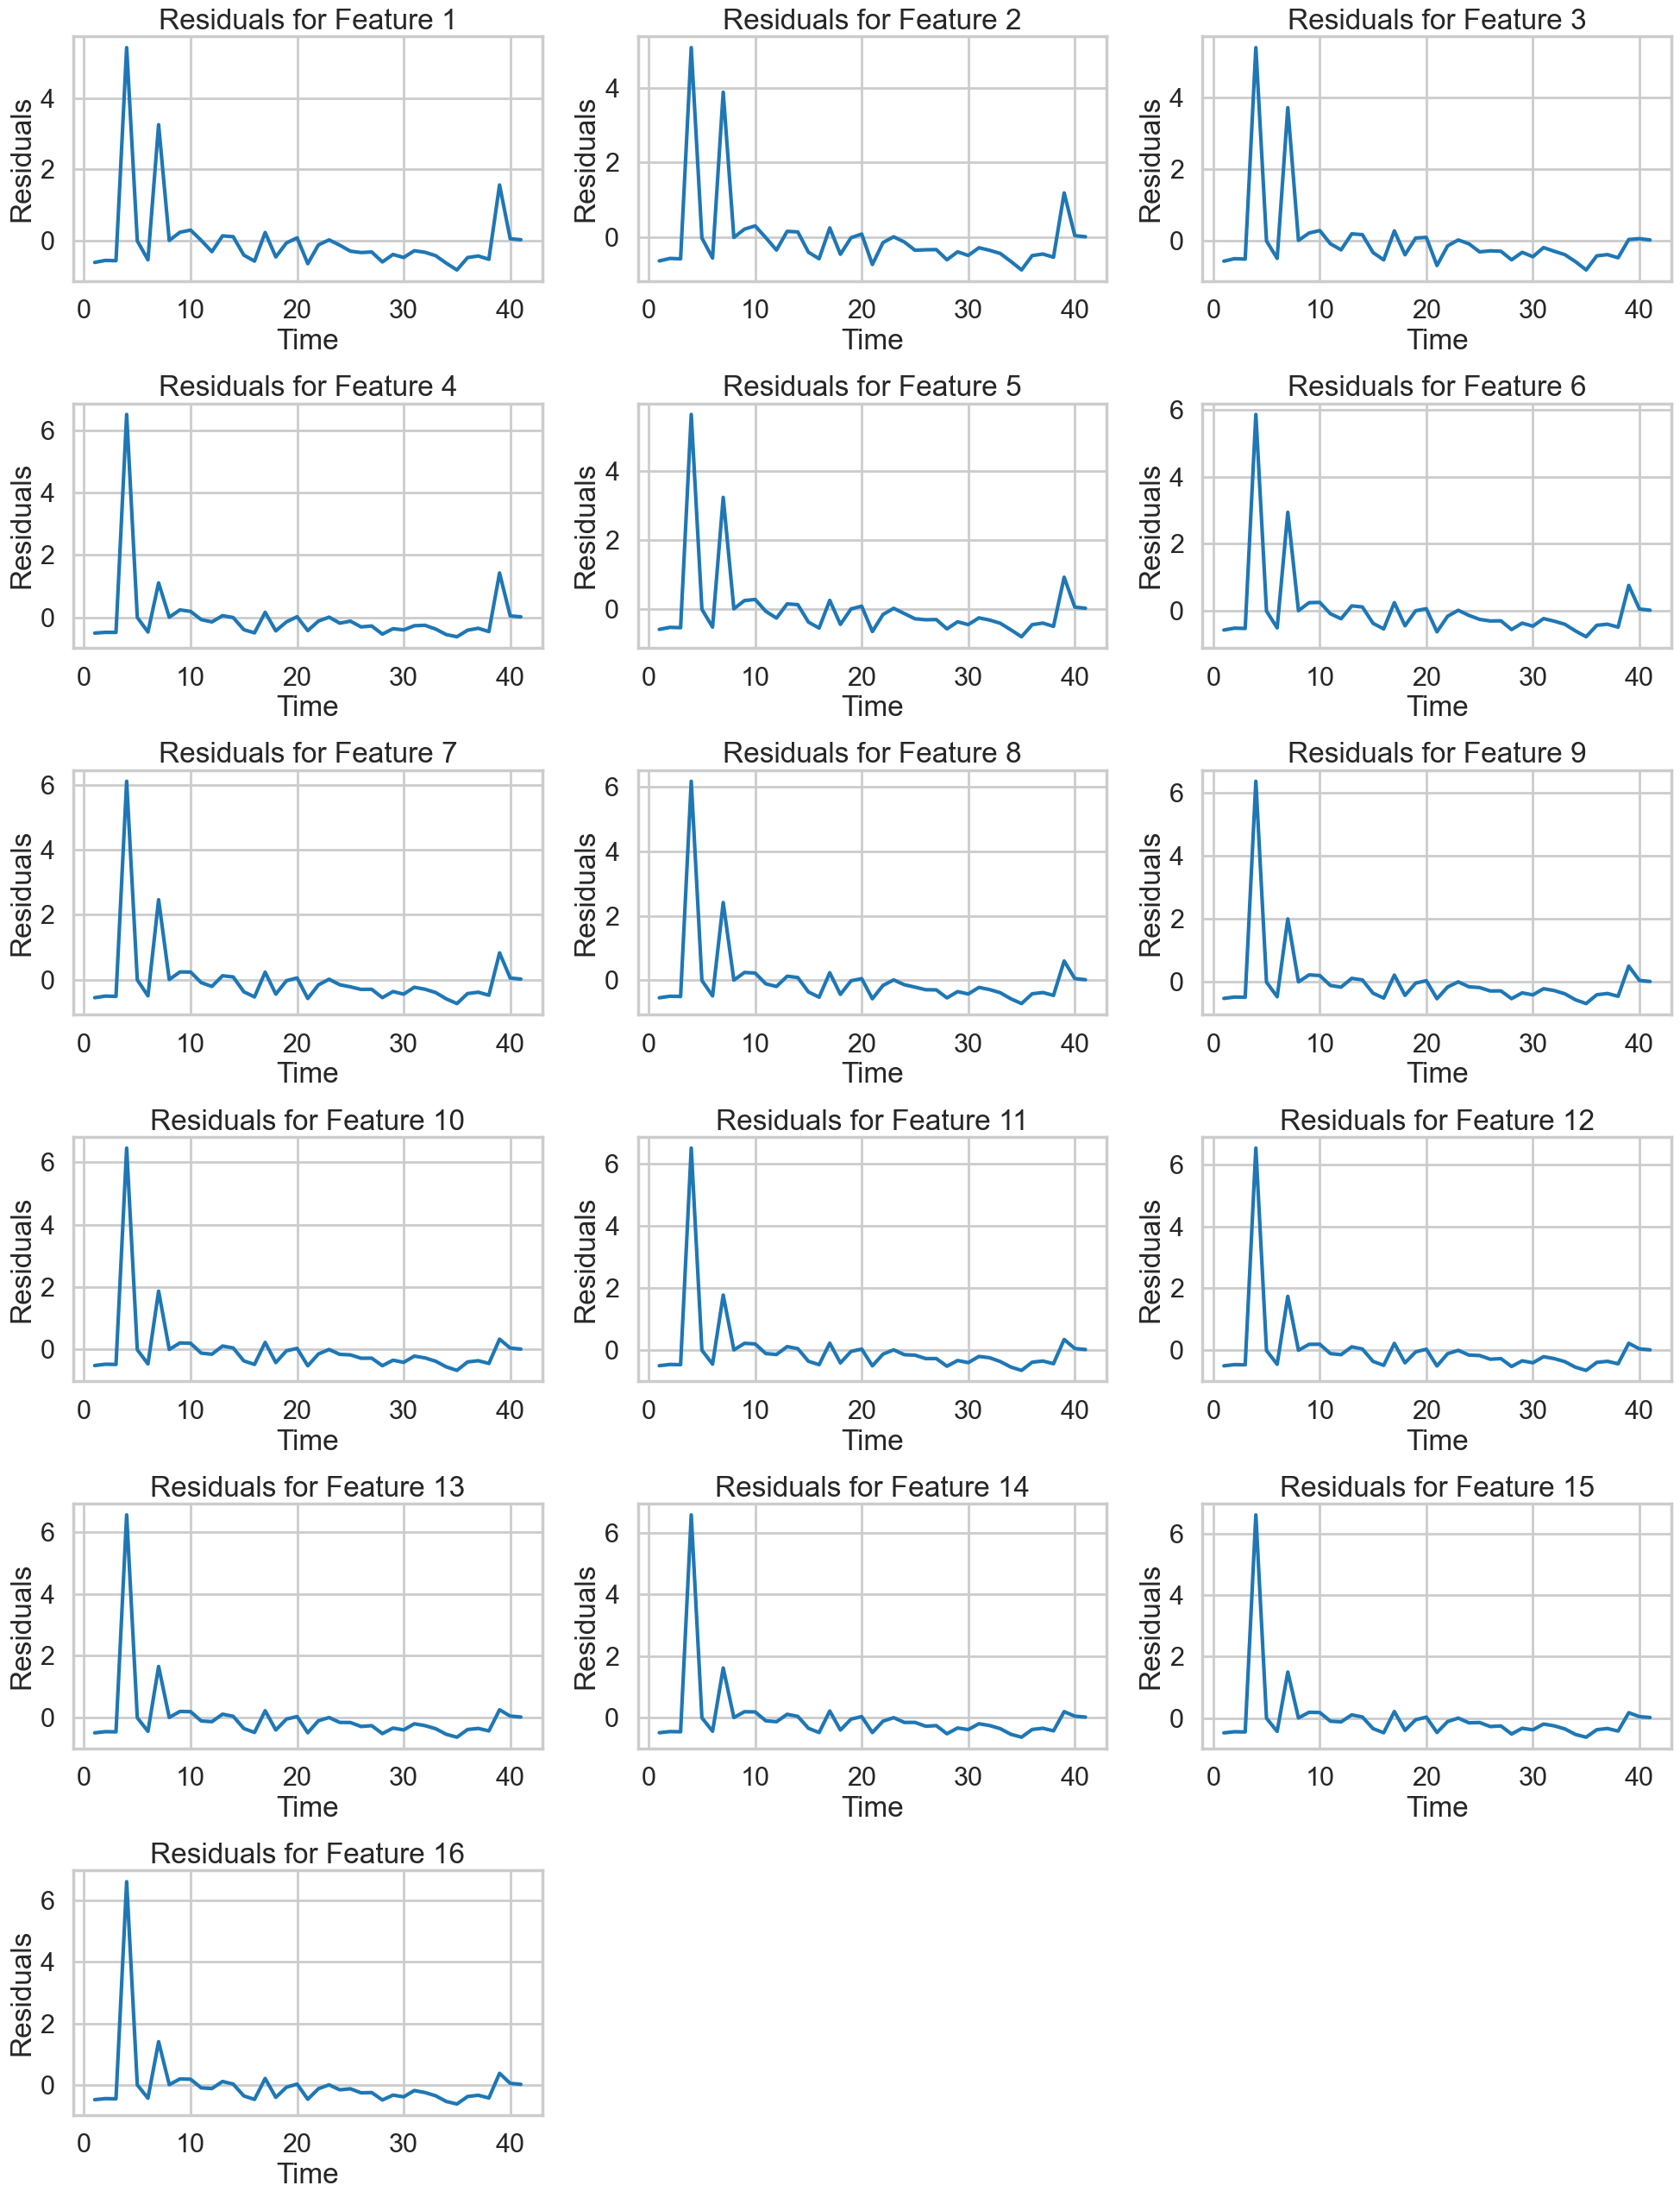

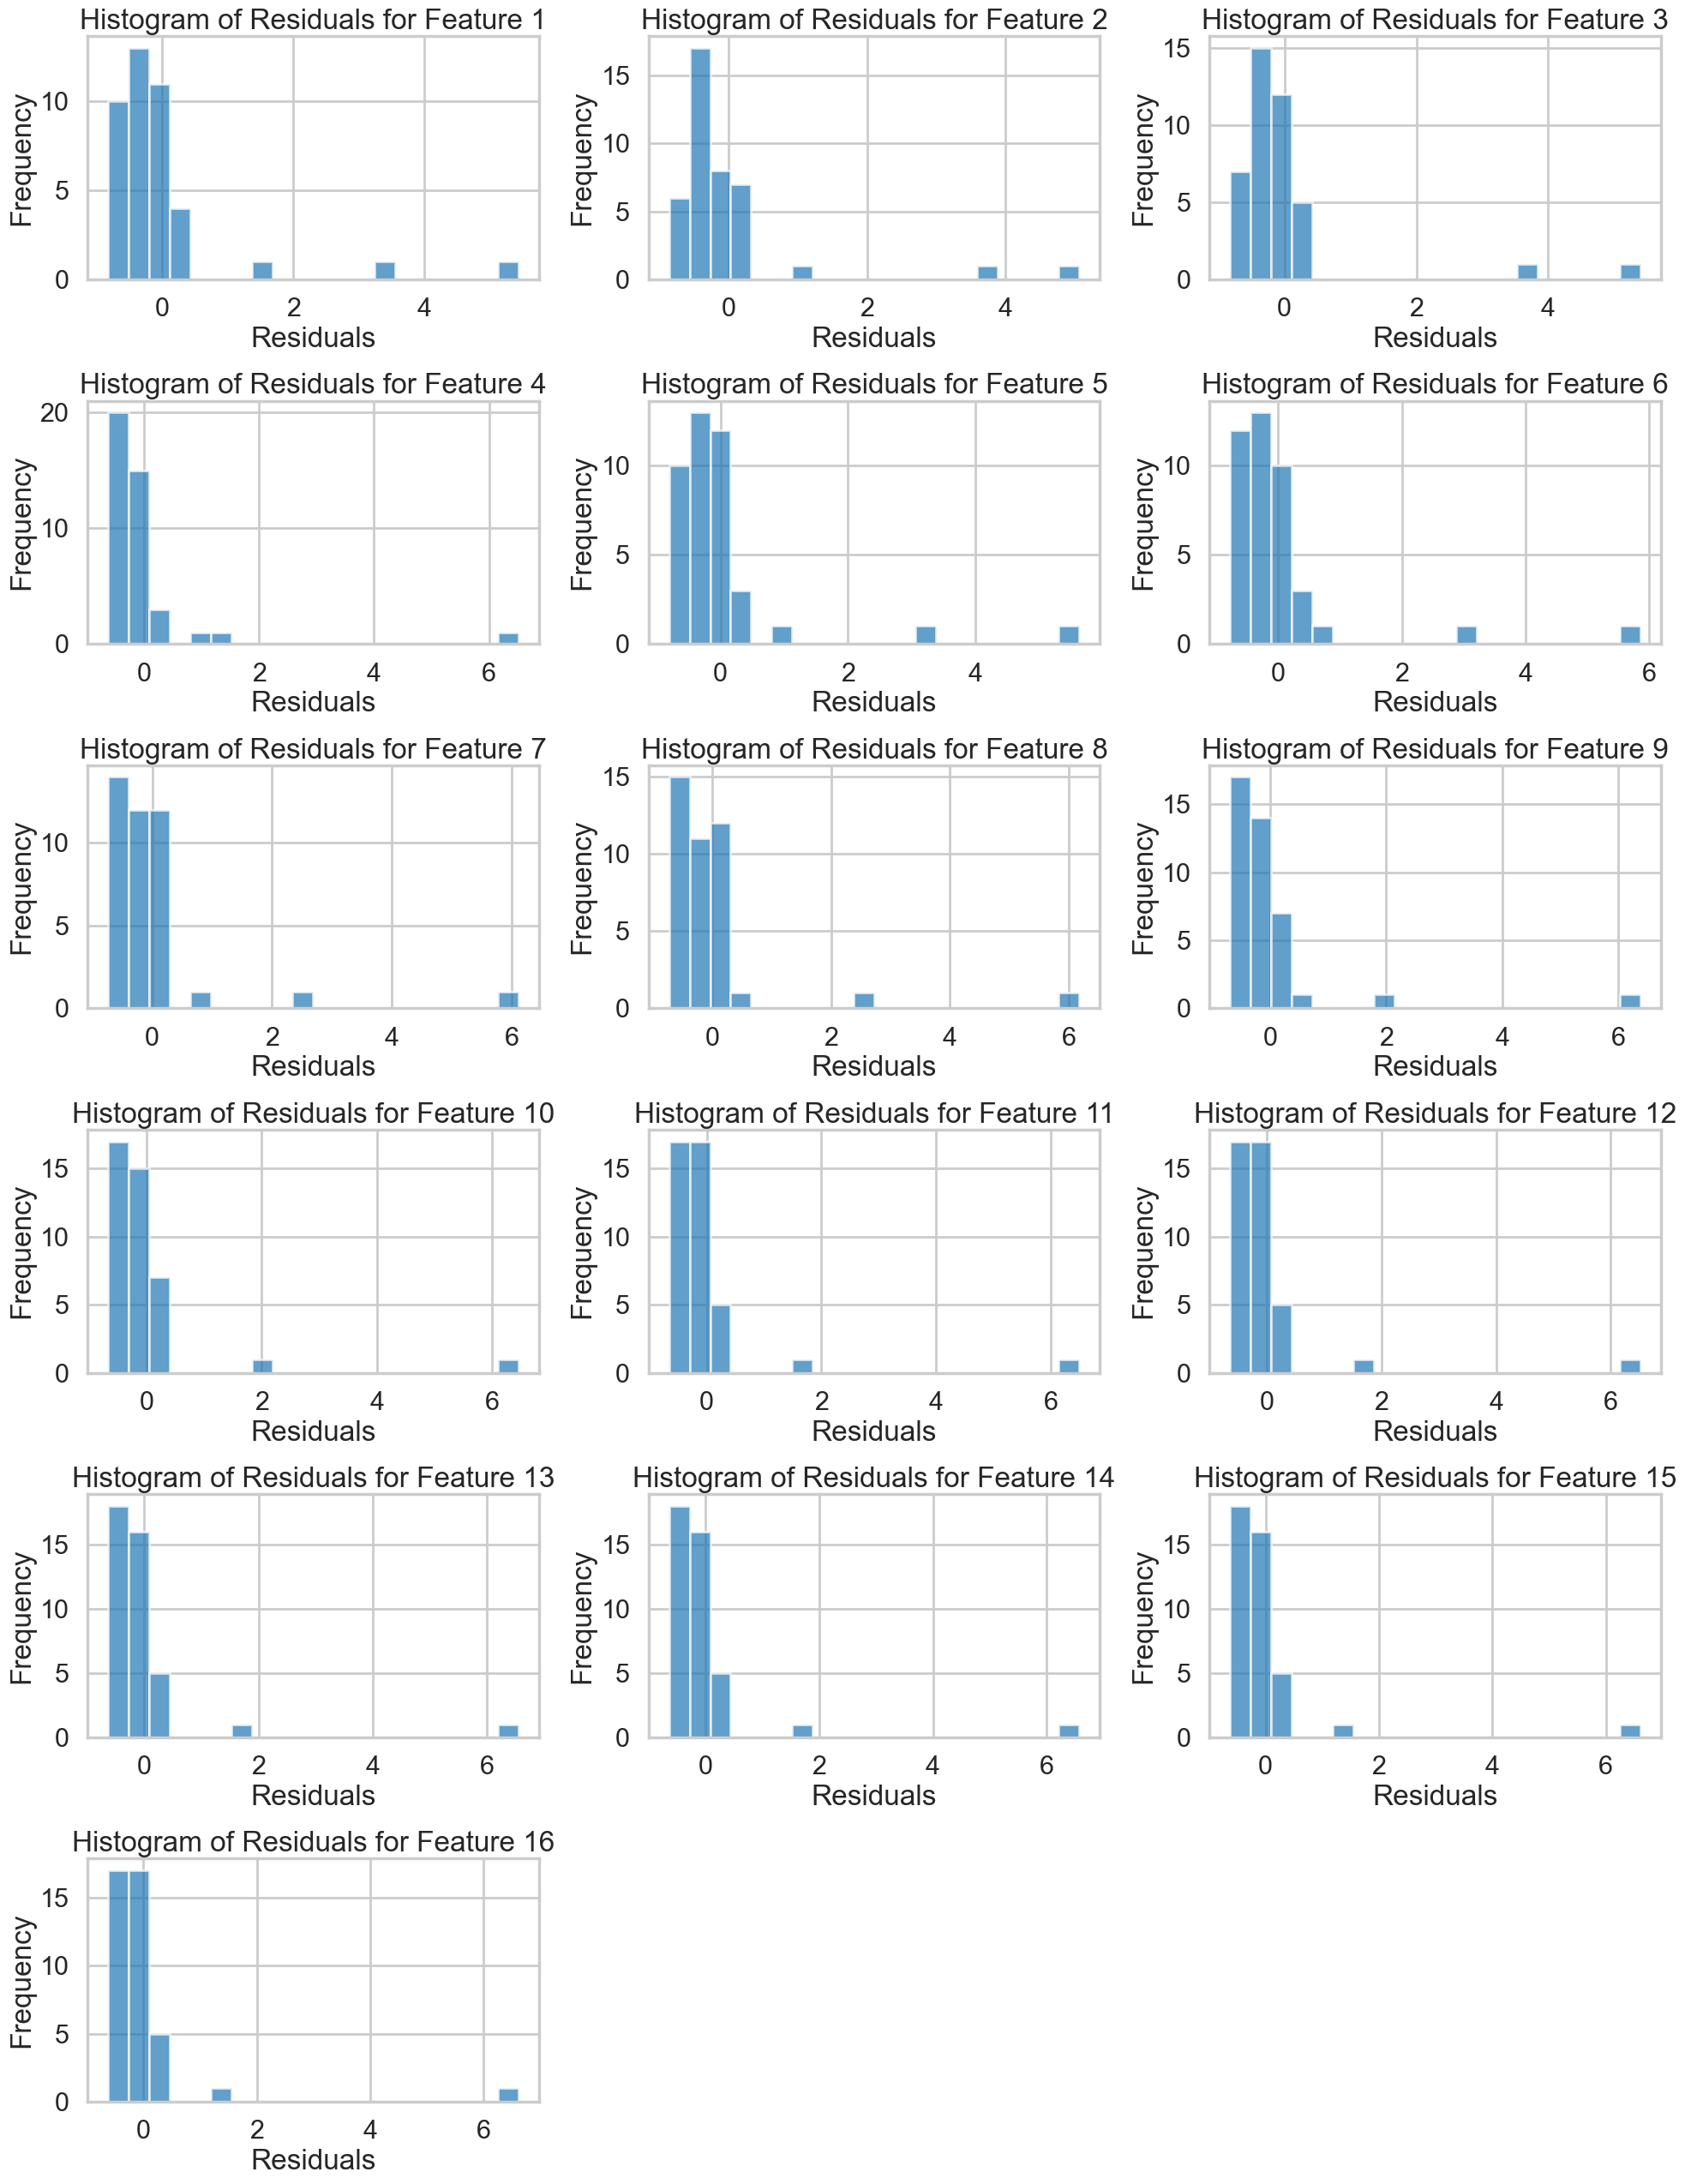

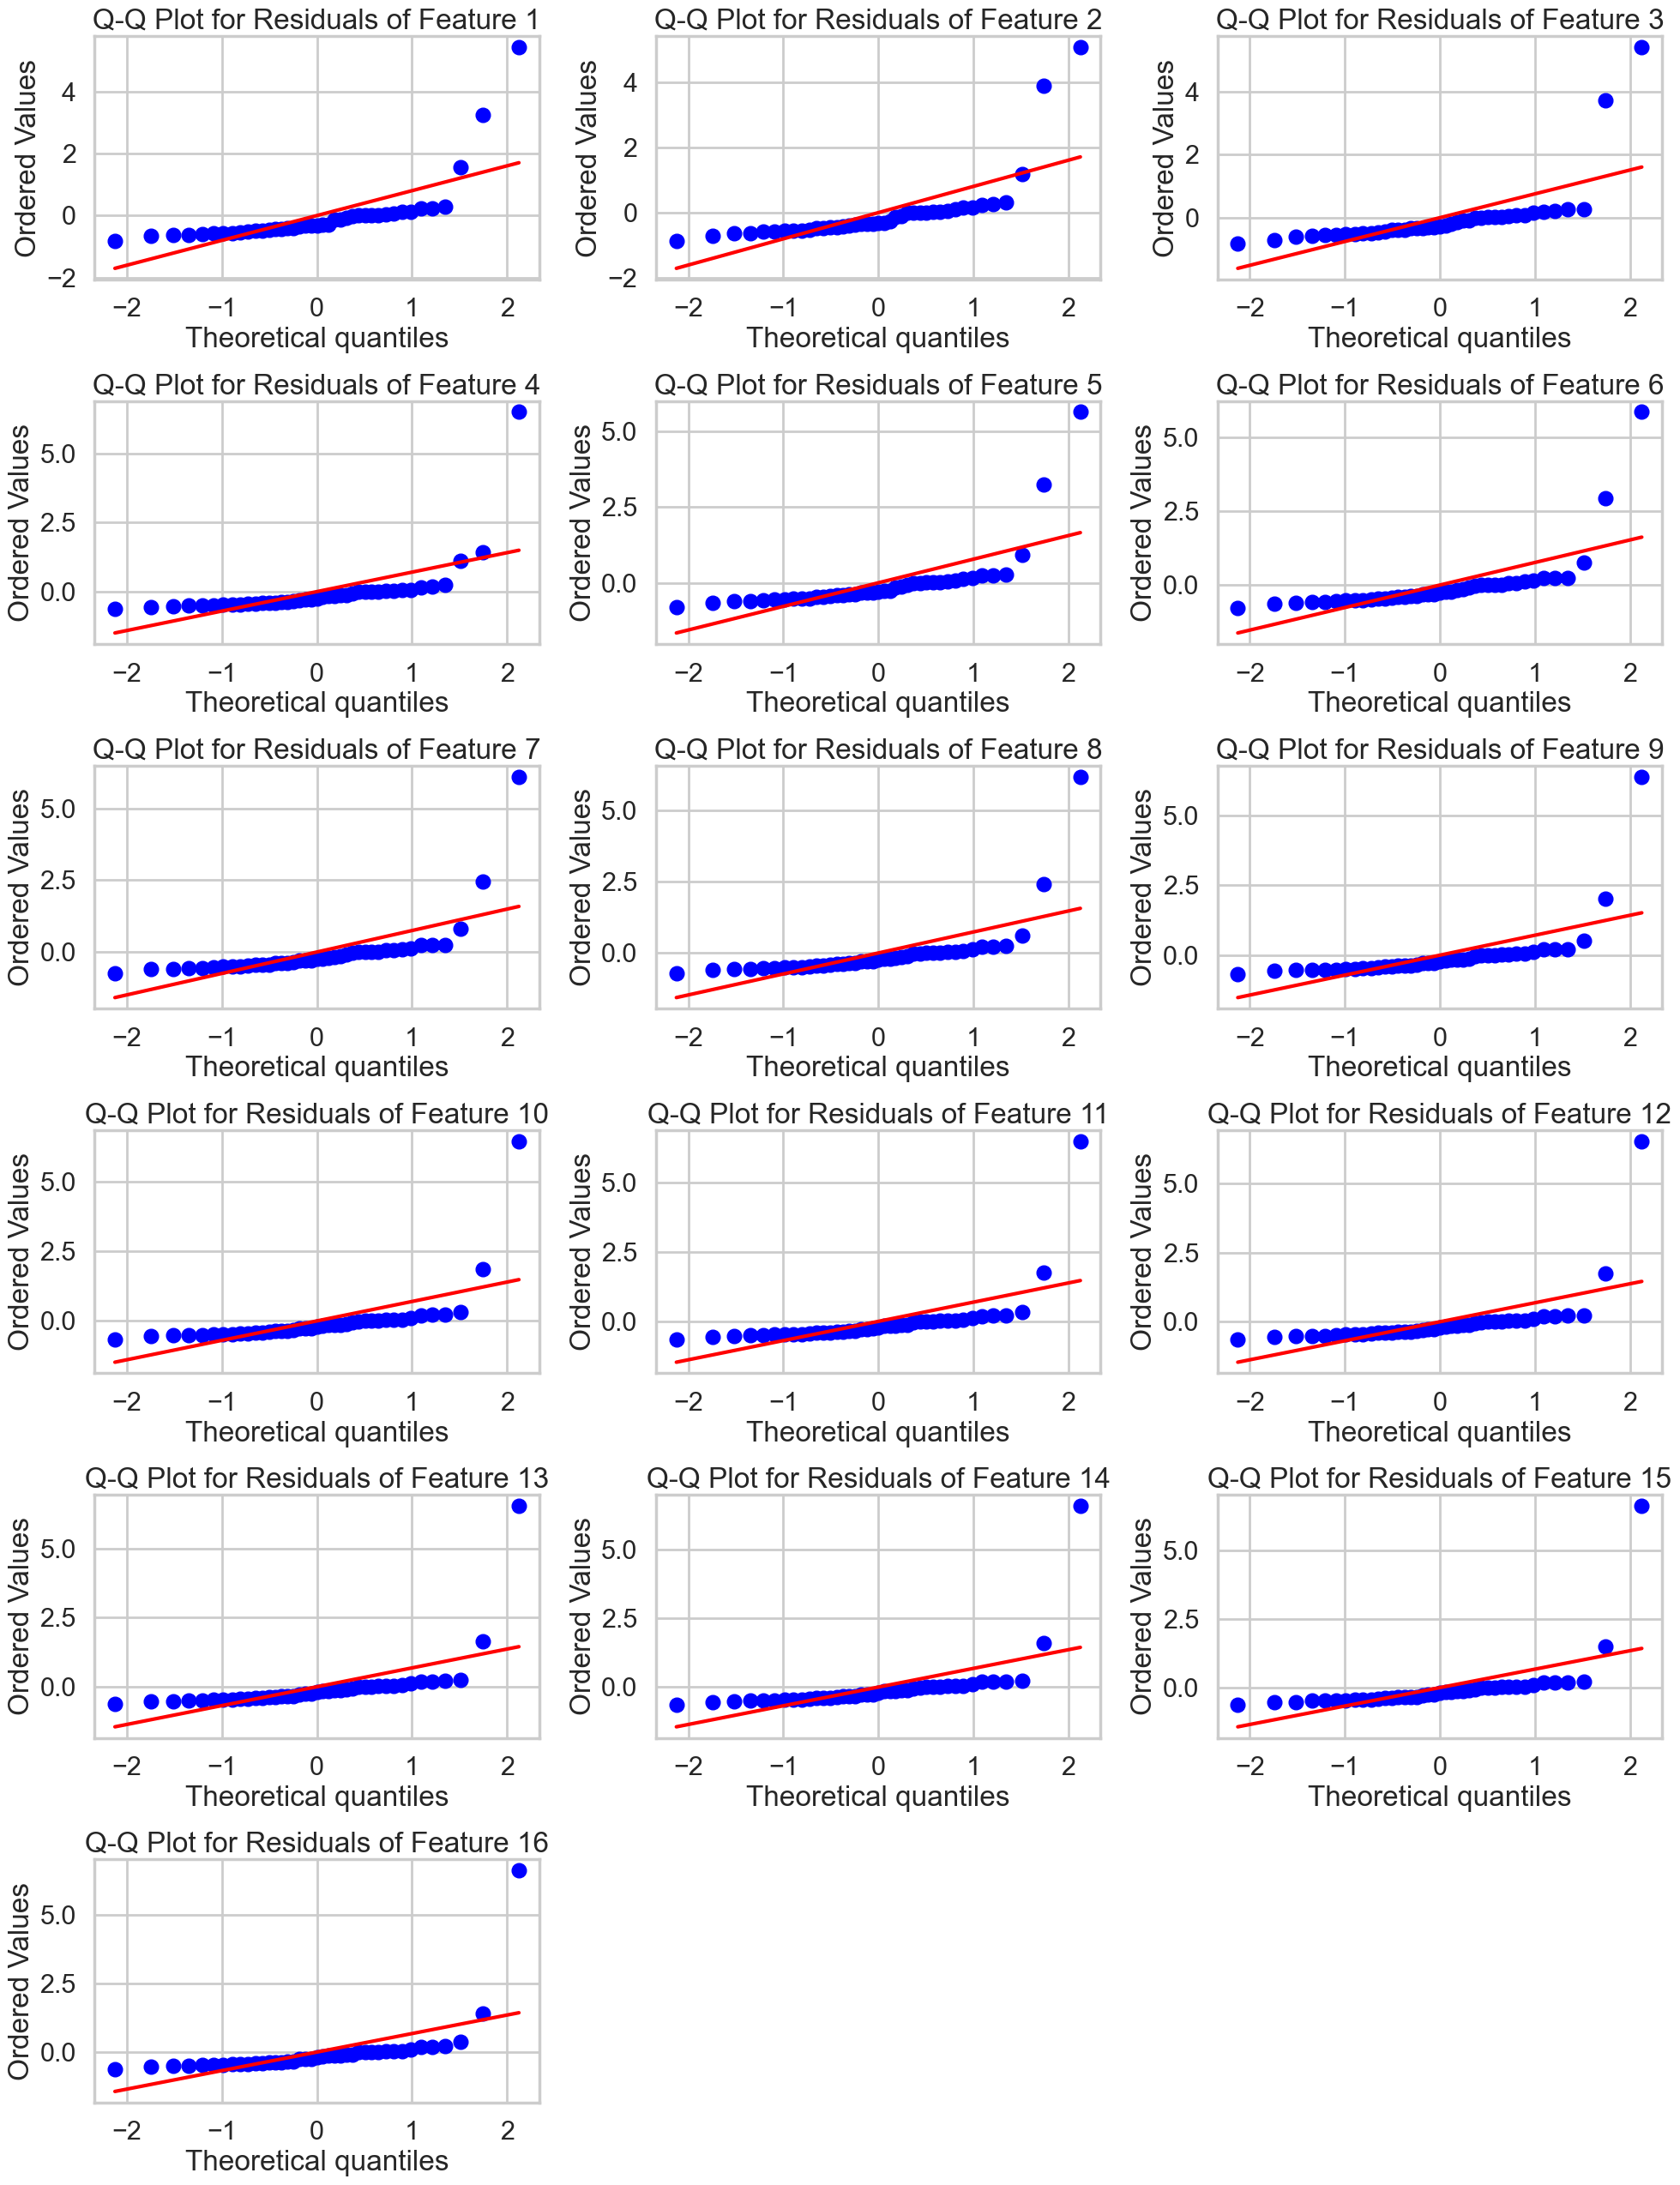

In [24]:
# Extract the residuals and ensure they are in DataFrame format
residuals = results_var.resid
residuals_df = pd.DataFrame(residuals, columns=X_train_df.columns)

# Plotting the residuals with more space
num_features = residuals_df.shape[1]
plt.figure(figsize=(20, 5 * num_features // 3))  # Adjust height based on number of features
for i in range(num_features):
    plt.subplot(num_features // 3 + 1, 3, i + 1)
    plt.plot(residuals_df.iloc[:, i])
    plt.title(f'Residuals for Feature {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Residuals')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase space between rows
plt.show()

# Optionally, plot the histogram of residuals
plt.figure(figsize=(20, 5 * num_features // 3))
for i in range(num_features):
    plt.subplot(num_features // 3 + 1, 3, i + 1)
    plt.hist(residuals_df.iloc[:, i], bins=20, alpha=0.7)
    plt.title(f'Histogram of Residuals for Feature {i+1}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase space between rows
plt.show()

# Optionally, create a Q-Q plot to check normality
plt.figure(figsize=(20, 5 * num_features // 3))
for i in range(num_features):
    plt.subplot(num_features // 3 + 1, 3, i + 1)
    stats.probplot(residuals_df.iloc[:, i], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for Residuals of Feature {i+1}')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase space between rows
plt.show()

In these models it appears that the first two models (ARIMA1 and ARIMA2) have lower residuals, as it also appears in the MSE-scores. In the ARIMA models I chose to use PCA to reduce the number of variables in the model. In the VaR modelling this simplification is less necessary. While the MSE-score appears much higher for the VAR predictor the AIC and BIC scores are substantially lower for the VAR model. 

Linear regression (without PCA)
Mean Squared Error (MSE): 795024.4536907848
R-squared Score: 0.8084225410973096

ARIMA 1
ARIMA MSE Scores: [0.8232445008828726, 0.28875381936427336, 0.16689813981394258, 0.4284484050792737, 0.0767696582109092]
Average MSE: 0.3568229046702543

ARIMA 2:
ARIMA2 MSE Scores: [1.925674247900199, 0.2028152275174579, 0.09855641689779224, 0.42116319640969735, 0.05163774483800012]
Average MSE: 0.5399693667126293

VAR MSE Scores: [354806659460.1925, 3258731.234438983, 235845996.07972065, 11479199.778941542]
Average MSE: 88764310846.8214

ARIMA model 1:
AIC                            296.384
BIC                            302.238

ARIMA model 2:
AIC                            137.651
BIC                            143.003

VaR model:
AIC:                     -144.141    BIC:                   -132.773

On the whole the VaR model is a better predictor for this data. 

In [26]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import pandas as pd

# Placeholder for metrics
var_mse_scores = []

# Cross-validation loop
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ensure X_train is a DataFrame
    X_train_df = pd.DataFrame(X_train)

    # Fit VAR model
    model_var = VAR(X_train_df)
    results_var = model_var.fit()

    # Forecasting
    y_pred = results_var.forecast(X_train_df.values[-results_var.k_ar:], steps=len(X_test))

    # Calculate and store MSE (assuming homelessness in California is the first column)
    mse = mean_squared_error(y_test, y_pred[:, 7])  # Replace 0 with the correct index if necessary
    var_mse_scores.append(mse)

# After cross-validation, train the final model on the full dataset
final_var_model = VAR(X_scaled)
final_var_results = final_var_model.fit()

# Forecast the value for 2023 (one step ahead)
forecast_steps = 1  # Predicting one step ahead (for 2023)
forecast_2023 = final_var_results.forecast(X_scaled[-final_var_results.k_ar:], steps=forecast_steps)

# Assuming the "homelessness in California" is the first column
predicted_homelessness_2023 = forecast_2023[0, 7]  # Change 0 to the appropriate index if necessary

# Print the predicted value for 2023
print(f"Predicted homelessness in California for 2023: {predicted_homelessness_2023}")

# Print MSE scores from cross-validation
print("VAR MSE Scores:", var_mse_scores)
print("Average MSE:", np.mean(var_mse_scores))


Predicted homelessness in California for 2023: -0.22667392024243643
VAR MSE Scores: [63378665480.25675, 3261736.6500149504, 235845833.0888102, 11479218.027624626]
Average MSE: 15907313067.005802


In [36]:
# Assuming 2023 is the last column in X_scaled and row 7 corresponds to California homelessness
california_index = 7  # Row index for California homelessness

# Reshape the predicted value to (1, 1) for inverse_transform
predicted_homelessness_scaled = np.array([[predicted_homelessness_2023]])  # Use your predicted value

# Use inverse_transform on just this single value for California homelessness
# The scaler expects the same number of features as were originally scaled
# Hence, provide the full row of features, but only replace the predicted value
X_scaled[california_index, year_2023_column_index] = predicted_homelessness_scaled

# Now apply inverse_transform to the entire row of California homelessness
X_california_rescaled = scaler.inverse_transform(X_scaled[california_index].reshape(1, -1))

# Extract the unscaled predicted value for 2023 (the last value in the row)
predicted_homelessness_california_2023 = X_california_rescaled[0, year_2023_column_index]

# Print the unscaled predicted value for California homelessness in 2023
print(f"Predicted homelessness in California for 2023 (original scale): {predicted_homelessness_california_2023}")


Predicted homelessness in California for 2023 (original scale): -693.7588135060032


/var/folders/3h/xf908vrj5mj7n9k2w1cj5_2h0000gn/T/ipykernel_72192/3189350105.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_scaled[california_index, year_2023_column_index] = predicted_homelessness_scaled


Actual California homeless population in 2023 is 136531, so maybe the VaR model is not our best fit and I need a seasonally adjusted model. 

In [30]:
# Fit ARIMA model on additional lags
mod2 = ARIMA(X_train_univariate, order=(4, 0, 0))  
result2 = mod2.fit()

# Predict using the ARIMA model
y_pred2 = result2.predict()

# Convert the prediction from Series to NumPy array and reshape it
y_pred2_array = y_pred2.values.reshape(-1, 1)  # Convert to NumPy array and reshape to 2D

# Reverse PCA transformation (ensure the right PCA object is used)
y_pred2_reversed = pca.inverse_transform(y_pred2_array)

# Reverse scaling (ensure you're using the same scaler as during the initial scaling)
y_pred_original = scaler.inverse_transform(y_pred2_reversed)

# Get the prediction for row index 7 (assuming row 7 corresponds to California)
california_homelessness_pred = y_pred_original[7, 0]
print(f"Predicted homelessness for California (2023): {california_homelessness_pred}")


Predicted homelessness for California (2023): 78561.04194729083


In the ARIMA2 there is a much more accurate prediction of homelessness in California. It is the model best suited to predict results, despite the limited years of data collection. It adequately captures the exponential curve in the data.